# The extremelly destructive Waldo Canyon Fire occured outside of Colorado Springs, CO in summer 2012

After starting on June 23rd the fire burned until July 10th, killing two people, buring over 18,000 acres, and destorying 346 homes. 

![The Waldo Canyon fire in Waldo Canyon, CO](https://upload.wikimedia.org/wikipedia/commons/0/03/Waldocanyon.jpg)

Image source: https://upload.wikimedia.org/wikipedia/commons/0/03/Waldocanyon.jpg

Source: [Remembering the Waldo Canyon Fire in Colorado Springs Ten Years Later (Colorado Public Radio)](https://www.cpr.org/2022/06/23/remembering-the-waldo-canyon-fire-in-colorado-springs-ten-years-later/)

In [1]:
# Import libraries

import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import keyring
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import xarray as xr


# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Create path to project directory
project_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'waldo-canyon')

# Create project directory
os.makedirs(project_dir, exist_ok=True)

In [3]:
# Define url for data
wc_gdf = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/Historic_Geomac_Perimeters_2012/FeatureServer/0/query"
    "?where=incidentname%20%3D%20'WALDO%20CANYON'"
    "%20AND%20latest%20%3D%20'Y'"
    "&outFields=*&outSR=4326&f=json"
    )

In [4]:
# Waldo, CO location
# From https://waterdata.usgs.gov/monitoring-location/07100750/#parameterCode=00065&period=P7D&showMedian=true
wc_lat = 38.8881111
wc_lon = -104.9356944

# Create a Folium map object
m = folium.Map(
    location=[wc_lat, wc_lon], 
    zoom_start=11,
    scrollWheelZoom=False
    )

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="ESRI World Imagery",
    overlay=False,
    control=True,
)
esri_world_imagery.add_to(m)

camp_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 2,
    "dashArray": "5, 5",
}

# Convert the GeoDataFrame to GeoJSON format
wc_geojson = wc_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
folium.GeoJson(
    wc_geojson,
    style_function=lambda feature: camp_style
    ).add_to(m)

# Add a marker for Paradise, CA
folium.Marker(location=[wc_lat, wc_lon], popup='Waldo Canyon, CO').add_to(m)

# Display the map as an HTML file or display it inline
m

# Map of the Waldo Canyon Fire perimeter, reaching from western Colorado Springs to Woodland Park, CO

### Data Description

The data used for this analysis is the NDVI (Normalized Difference Vegetation Index) derived from reflectance bands measured by the Moderate Resolution Imaging Spectroradiometer (MODIS) aboard the satellite Aqua. MODIS measures Near-InfraRed (NIR) radiation, as well as visible light wavelengths and calculates the normalized difference vegetation index (NDVI) through the formula: NDVI = (NIR - Red) / (NIR + Red). Healthy (green) vegetation reflects a greater proportion of NIR to (NIR + Red) wavelengths than unhealthy (yellow or red) vegeatation, therefore a higher NDVI value reflects healthier vegetation. NDVI data are collected over a 16 day period at a 250 meter resolution and the best pixel value (selecting for low cloud coverage, low view angle, and highest resultant NVDI value) is used for that interval.

### Citation: 

Didan, K. (2015). <i>MYD13Q1 MODIS/Aqua Vegetation Indices 16-Day L3 Global 250m SIN Grid V006</i> [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-09-25 from https://doi.org/10.5067/MODIS/MYD13Q1.006

In [5]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="wc-ndvi",
    ea_dir=project_dir,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2010, 2020],
    polygon=wc_gdf,
)

# # Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

# ndvi_downloader

In [6]:
ndvi_path_list = (
    glob(os.path.join(ndvi_downloader.data_dir, '*', '*NDVI*.tif')))

In [7]:
doy_start = -19
doy_end = -12
scale_factor = 10000

# Create for loop for iterating over files

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

In [8]:
# Stack arrays
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])

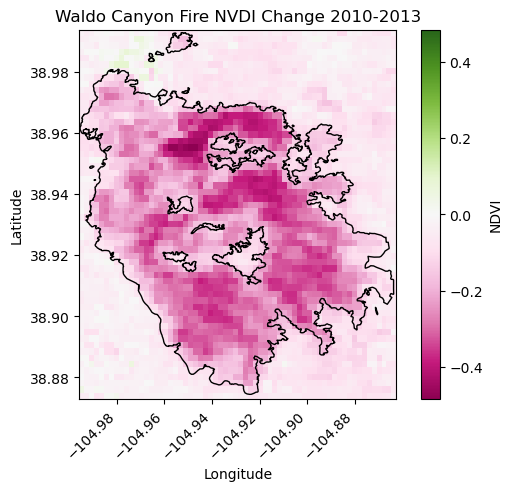

In [9]:
# Calculation of the change in NDVI pre and post fire
dndvi_da = (ndvi_ds
    .sel(date='2013')
    .mean('date')
    .NDVI 
- ndvi_ds
    .sel(date='2010')
    .mean('date')
    .NDVI
)

# Plot of the change in NDVI pre and post fire
dndvi_da.plot(cmap=plt.colormaps['PiYG'])
wc_gdf.plot(facecolor='none', ax=plt.gca())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Waldo Canyon Fire NVDI Change 2010-2013')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [10]:
# Define the area outside surrounding the fire boundary
square_gdf = gpd.GeoDataFrame(geometry=wc_gdf.envelope)


# Get the area outside the fire boundary
out_gdf = square_gdf.overlay(wc_gdf, how="difference")

In [11]:
# Clip NDVI to boundaries
ndvi_fire_ds = ndvi_ds.rio.clip(wc_gdf.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)


# Check coordinate reference frames for datasets
#  ndvi_ds.rio.crs, camp_gdf.crs

In [12]:
# Calculate average NDVI for each year and save as a dataframe
ndvi_fire_df = (ndvi_fire_ds
 .groupby(ndvi_fire_ds.date.dt.year)
 .mean(...).NDVI
 .to_dataframe()[['NDVI']]
)

ndvi_out_df = (ndvi_out_ds
 .groupby(ndvi_fire_ds.date.dt.year)
 .mean(...).NDVI
 .to_dataframe()[['NDVI']]
)

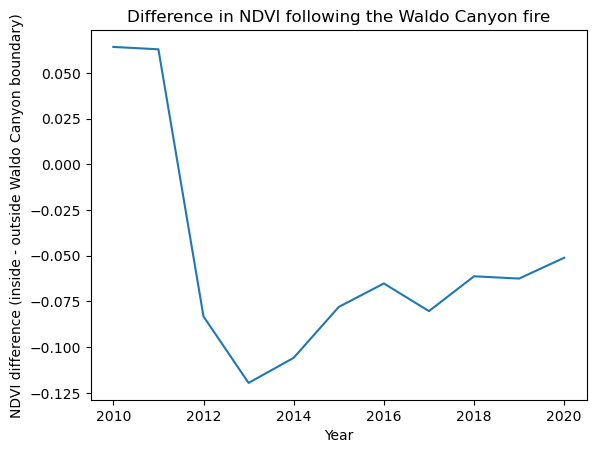

In [13]:
# Calculate and plot the difference in NDVI inside and outside the fire boundary
(ndvi_fire_df - ndvi_out_df).plot()
plt.xlabel('Year')
plt.ylabel('NDVI difference (inside - outside Waldo Canyon boundary)')
plt.title('Difference in NDVI following the Waldo Canyon fire')
plt.legend('', frameon=False)


### Vegetation declined drastically after the Waldo Canyon fire and still has not fully recovered

Peak NDVI dropped drastically after the 2012 Waldo Canyon fire within it's perimeter compared to the surrounding area, reaching a minimum NDVI in the year following the fire. Since then NDVI has increased, but NDVI within the burn area has remained significantly lower than in the surrounding areas.

In [14]:
%%bash
jupyter nbconvert 03-modis-ndvi.ipynb --to html --no-input

[NbConvertApp] Converting notebook 03-modis-ndvi.ipynb to html
[NbConvertApp] Writing 681759 bytes to 03-modis-ndvi.html
